In [1]:
using IntervalSets, Distributions, MultivariateStats,  ValueShapes, TypedTables
using Random, LinearAlgebra, Statistics, Distributions, StatsBase, ArraysOfArrays
using JLD2, HDF5, CSV, LaTeXStrings
using Measurements, HypothesisTests

In [2]:
using Flux
using Flux: logitcrossentropy, normalise, onecold, onehotbatch, crossentropy, throttle
using Statistics: mean
using Parameters: @with_kw
using Flux: @epochs

In [3]:
using PyPlot
using BAT

In [4]:
function Statistics.cov(dist::BAT.FunnelDistribution)
    cov(nestedview(rand(BAT.bat_determ_rng(), BAT.sampler(dist), 10^5)))
end

accuracy(x, y, model) = mean(onecold(model(x)) .== onecold(y))

# Function to build confusion matrix
function confusion_matrix(X, y, model)
    ŷ = onehotbatch(onecold(model(X)), 0:1)
    # onecold([true, false, false], [:a, :b, :c]) -> :a
    # onehotbatch -> matrix of cathegorical variables
    y * transpose(ŷ)
end

loss(x, y) = crossentropy(model(x), y) 

evalcb = () -> begin 
    los_train = loss(x_train, y_train)
    lost_test = loss(x_test, y_test)
    @info(los_train, lost_test)
end

#3 (generic function with 1 method)

In [164]:
convergence = BrooksGelmanConvergence(
    threshold = 1.1, #Change up
    corrected = false
)

init = MCMCInitStrategy(
    init_tries_per_chain = 8..128,
    max_nsamples_init = 250,
    max_nsteps_init = 250,
    max_time_init = 50
)

burnin = MCMCBurninStrategy(
    max_nsamples_per_cycle = 1000,
    max_nsteps_per_cycle = 10000,
    max_time_per_cycle = 250,
    max_ncycles = 100
)

n_dim = 5
algorithm = MetropolisHastings()
n_chains = 10
n_samples = 10^4

10000

In [165]:
dis = BAT.MultimodalCauchy(µ=1.,σ=0.5,n=n_dim)

BAT.MultimodalCauchy{MixtureModel{Univariate,Continuous,Cauchy{Float64},Float64},Product{Continuous,Distribution{Univariate,Continuous},Array{Distribution{Univariate,Continuous},1}}}(
bimodals: MixtureModel{Cauchy{Float64}}(K = 2)
components[1] (prior = 0.5000): Cauchy{Float64}(μ=-1.0, σ=0.5)
components[2] (prior = 0.5000): Cauchy{Float64}(μ=1.0, σ=0.5)

σ: 0.5
n: 5
dist: Product{Continuous,Distribution{Univariate,Continuous},Array{Distribution{Univariate,Continuous},1}}(v=Distribution{Univariate,Continuous}[MixtureModel{Cauchy{Float64}}(K = 2)
components[1] (prior = 0.5000): Cauchy{Float64}(μ=-1.0, σ=0.5)
components[2] (prior = 0.5000): Cauchy{Float64}(μ=1.0, σ=0.5)
, MixtureModel{Cauchy{Float64}}(K = 2)
components[1] (prior = 0.5000): Cauchy{Float64}(μ=-1.0, σ=0.5)
components[2] (prior = 0.5000): Cauchy{Float64}(μ=1.0, σ=0.5)
, Cauchy{Float64}(μ=0.0, σ=0.5), Cauchy{Float64}(μ=0.0, σ=0.5), Cauchy{Float64}(μ=0.0, σ=0.5)])
)


In [166]:
iid_sample = bat_sample(dis, n_samples*n_chains).result;

mcmc_sample = bat_sample(
    dis, 
    (n_samples, n_chains),
    algorithm,
    max_time = Inf,
    init = init,
    burnin = burnin,
    convergence = convergence,
    strict = true,
    filter = true
).result;


┌ Info: Initializing new RNG of type Random123.Philox4x{UInt64,10}
└ @ BAT /Users/vhafych/MPP-Server/gitrepos/BAT.jl/src/algotypes/bat_default.jl:44
┌ Info: Using sampling algorithm IIDSampling()
└ @ BAT /Users/vhafych/MPP-Server/gitrepos/BAT.jl/src/algotypes/bat_default.jl:44
┌ Info: Initializing new RNG of type Random123.Philox4x{UInt64,10}
└ @ BAT /Users/vhafych/MPP-Server/gitrepos/BAT.jl/src/algotypes/bat_default.jl:44
┌ Info: Trying to generate 10 viable MCMC chain(s).
└ @ BAT /Users/vhafych/MPP-Server/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:193
┌ Info: Selected 10 MCMC chain(s).
└ @ BAT /Users/vhafych/MPP-Server/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:304
┌ Info: Begin tuning of 10 MCMC chain(s).
└ @ BAT /Users/vhafych/MPP-Server/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:65
┌ Info: MCMC Tuning cycle 1 finished, 10 chains, 10 tuned, 0 converged.
└ @ BAT /Users/vhafych/MPP-Server/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:98
┌ Info: MCMC Tuning cycle 2 fi

In [167]:
mcmc_resampled = bat_sample(mcmc_sample, n_samples*n_chains).result;

┌ Info: Initializing new RNG of type Random123.Philox4x{UInt64,10}
└ @ BAT /Users/vhafych/MPP-Server/gitrepos/BAT.jl/src/algotypes/bat_default.jl:44
┌ Info: Using sampling algorithm OrderedResampling()
└ @ BAT /Users/vhafych/MPP-Server/gitrepos/BAT.jl/src/algotypes/bat_default.jl:44


In [168]:
data_a = flatview(unshaped.(iid_sample.v));
data_b = flatview(unshaped.(mcmc_resampled.v));

x_d = hcat(data_a, data_b)
y_d = [repeat([0], size(data_a)[2]); repeat([1], size(data_b)[2])]
klasses = [0, 1]
onehot_labels = onehotbatch(y_d, klasses)

data_length = size(x_d)[2]

train_indices = [1:3:data_length; 2:3:data_length]
test_indices = collect(3:3:data_length)

x_train = x_d[:, train_indices]
y_train = onehot_labels[:,train_indices]

x_test = x_d[:, test_indices]
y_test = onehot_labels[:,test_indices]

train_data = Flux.Data.DataLoader(x_train, y_train, batchsize=256, shuffle=true);

In [169]:
model = Chain(Flux.Dense(n_dim, 20, sigmoid), Flux.Dense(20, 2), softmax)

optimiser = ADAM()

loss_test_f = Float64[]
loss_train_f = Float64[]

@time @epochs 200 Flux.train!(
    loss, 
    Flux.params(model), train_data, 
    optimiser, 
    cb = throttle(evalcb, 80)
)

┌ Info: Epoch 1
└ @ Main /Users/vhafych/.julia/packages/Flux/Fj3bt/src/optimise/train.jl:121
┌ Info: 0.7711247
│   lost_test = 0.7711108
└ @ Main In[4]:20
┌ Info: Epoch 2
└ @ Main /Users/vhafych/.julia/packages/Flux/Fj3bt/src/optimise/train.jl:121
┌ Info: 0.67925715
│   lost_test = 0.6793075
└ @ Main In[4]:20
┌ Info: Epoch 3
└ @ Main /Users/vhafych/.julia/packages/Flux/Fj3bt/src/optimise/train.jl:121
┌ Info: 0.67650044
│   lost_test = 0.6763119
└ @ Main In[4]:20
┌ Info: Epoch 4
└ @ Main /Users/vhafych/.julia/packages/Flux/Fj3bt/src/optimise/train.jl:121
┌ Info: 0.67483616
│   lost_test = 0.67453784
└ @ Main In[4]:20
┌ Info: Epoch 5
└ @ Main /Users/vhafych/.julia/packages/Flux/Fj3bt/src/optimise/train.jl:121
┌ Info: 0.67373747
│   lost_test = 0.6733379
└ @ Main In[4]:20
┌ Info: Epoch 6
└ @ Main /Users/vhafych/.julia/packages/Flux/Fj3bt/src/optimise/train.jl:121
┌ Info: 0.67305326
│   lost_test = 0.67254955
└ @ Main In[4]:20
┌ Info: Epoch 7
└ @ Main /Users/vhafych/.julia/packages/Flux/Fj

 81.635618 seconds (874.01 M allocations: 40.230 GiB, 7.42% gc time)


In [170]:
accuracy_score = accuracy(x_test, y_test, model)

0.5569958292075494

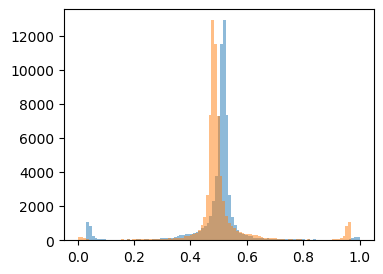

In [171]:
fig, ax = plt.subplots(1,1, figsize=(4,3))

x_tmp = model(x_test)[1,:]
y_tmp = model(x_test)[2,:]
ax.hist(x_tmp, bins=100, alpha=0.5)
ax.hist(y_tmp, bins=100, alpha=0.5);

In [172]:
ApproximateTwoSampleKSTest(x_tmp, y_tmp)

┌ Warning: This test is inaccurate with ties
└ @ HypothesisTests /Users/vhafych/.julia/packages/HypothesisTests/5rgiE/src/kolmogorov_smirnov.jl:167


Approximate two sample Kolmogorov-Smirnov test
----------------------------------------------
Population details:
    parameter of interest:   Supremum of CDF differences
    value under h_0:         0.0
    point estimate:          0.3994959042218026

Test summary:
    outcome with 95% confidence: reject h_0
    two-sided p-value:           <1e-99

Details:
    number of observations:   [66654,66654]
    KS-statistic:              72.93071005282401


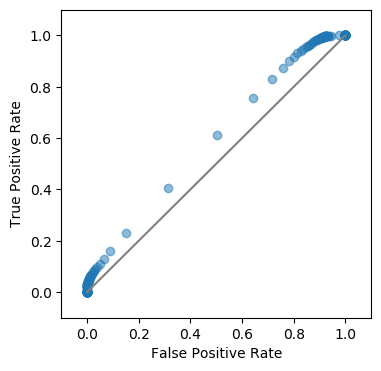

(-0.1, 1.1)

In [173]:
c_range = 0.0:0.005:1

function def_roc_vals(ind1, ind2; c_range = c_range)

    tA_array = Float64[]
    fA_array = Float64[]

    for c in c_range

        t_A = y_test[ind1,:]
        t_B = y_test[ind2,:]

        p = softmax(model(x_test), dims=1) .> c

        p_A = p[ind1,:]
        p_B = p[ind2,:]

        true_A = sum(t_A.*p_A)/sum(t_A)
        false_A = sum(.!t_A.*p_A) / sum(t_B)

        append!(tA_array, true_A)
        append!(fA_array, false_A)
    end
    
    return (fA_array, tA_array)
    
end

A_f, A_t = def_roc_vals(1, 2)

colors_a = plt.cm.terrain(range(0, stop=1, length = length(c_range)));

fig, ax = plt.subplots(1,1, figsize=(4,4))
ax.scatter(A_f, A_t, alpha=0.5, color=PyPlot.ColorMap("tab10").colors[1])
ax.plot(0:0.1:1, 0:0.1:1, color="gray")
ax.set_xlabel("False Positive Rate")
ax.set_ylabel("True Positive Rate")
ax.set_xlim(-0.1,1.1)
ax.set_ylim(-0.1,1.1)

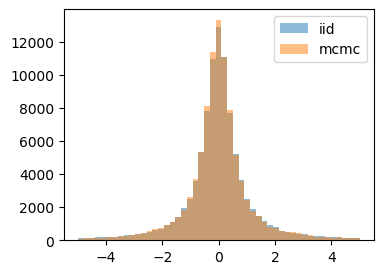

PyObject <matplotlib.legend.Legend object at 0x7f96368387d0>

In [174]:
dim = 3

fig, ax = plt.subplots(1,1, figsize=(4,3))

ax.hist(data_a[dim,:], bins=range(-5, stop=5, length=50), alpha=0.5, label="iid")
ax.hist(data_b[dim,:], bins=range(-5, stop=5, length=50), alpha=0.5, label="mcmc")

# ax.set_xlim(-50, 50)

ax.legend()